# Text Classification with `word2vec`
 
#### By: Tu My DOAN & Sali Dauda MOHAMNMED

# Libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
import matplotlib.pyplot as plt
from datetime import datetime
import logging
from xml.dom import minidom
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import keras
from keras import Sequential
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding, Flatten
from keras.models import Sequential,Input,Model, load_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
print("Keras version: {}".format(keras.__version__))
print("TensorFlow version: {}".format(tf.__version__))
%matplotlib inline

Using TensorFlow backend.


Keras version: 2.2.4
TensorFlow version: 1.10.0


# Data pre-processing

### Train data

In [2]:
train = pd.read_csv('news_datafile.csv')
train.head()

,id,file,label,content
0,1,1.xml,0,Showers continued throughout the week in\nthe ...
1,2,2.xml,0,Standard Oil Co and BP North America\nInc said...
2,3,3.xml,0,Texas Commerce Bancshares Inc's Texas\nCommerc...
3,4,4.xml,0,BankAmerica Corp is not under\npressure to act...
4,5,5.xml,0,The U.S. Agriculture Department\nreported the ...


In [7]:
train.label.head()

0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int64

In [8]:
train.content.head()

0    Showers continued throughout the week in\nthe ...
1    Standard Oil Co and BP North America\nInc said...
2    Texas Commerce Bancshares Inc's Texas\nCommerc...
3    BankAmerica Corp is not under\npressure to act...
4    The U.S. Agriculture Department\nreported the ...
Name: content, dtype: object

In [12]:
train.describe()

,id,label
count,4800.000000,4800.000000
mean,2503.911250,0.203125
std,1446.821421,0.402367
min,1.000000,0.000000
25%,1247.500000,0.000000
50%,2508.500000,0.000000
75%,3759.250000,0.000000
max,5000.000000,1.000000


In [3]:
train['label'].value_counts(dropna=False)

0    3825
1     975
Name: label, dtype: int64

In [11]:
train[train['content'].isnull()]

,id,file,label,content
28,30,30.xml,0,NaN
29,31,31.xml,0,NaN
71,76,76.xml,0,NaN
72,77,77.xml,0,NaN
73,78,78.xml,0,NaN
86,92,92.xml,0,NaN
88,94,94.xml,0,NaN
89,95,95.xml,0,NaN
92,99,99.xml,0,NaN
94,101,101.xml,0,NaN


In [4]:
train_new = train.dropna()

In [14]:
train_new.describe()

,id,label
count,4402.000000,4402.000000
mean,2491.386870,0.209905
std,1442.479033,0.407287
min,1.000000,0.000000
25%,1237.250000,0.000000
50%,2501.500000,0.000000
75%,3744.750000,0.000000
max,4999.000000,1.000000


In [5]:
train_new['label'].value_counts()

0    3478
1     924
Name: label, dtype: int64

### Test data

In [6]:
df_test = pd.read_csv("./dmdata/test.csv")
df_test.head()

,id,file,earnings: 0 no/ 1 yes
0,20,20.xml,NaN
1,47,47.xml,NaN
2,57,57.xml,NaN
3,66,66.xml,NaN
4,88,88.xml,NaN


In [7]:
def read_xml(xml_list):
    empty_content = []
    df = pd.DataFrame(columns=['content','file'])
    for file_name in xml_list:
        mydoc = minidom.parse("./dmdata/"+file_name)
        items = mydoc.getElementsByTagName('BODY')
        if items[0].firstChild != None:
            content = items[0].firstChild.data
            df = df.append({'content':content, 'file':file_name},ignore_index=True)
        else: 
            empty_content.append(str(file_name))
            df = df.append({'content':"", 'file':file_name},ignore_index=True)
    return df, empty_content
empty_content_lst = []
df_xml, empty_content_lst = read_xml(df_test.file.values)
df_xml.head()

,content,file
0,Legislation to require disclosure of\ncredit c...,20.xml
1,"inflation\nplan, initially hailed at home and ...",47.xml
2,The Commodity Credit Corporation (CCC)\nannoun...,57.xml
3,"Shr 27 cts vs 29 cts\n Net 13,555,000 vs 14...",66.xml
4,Sorg Inc said a group composed of\none-third o...,88.xml


In [9]:
len(empty_content_lst),empty_content_lst

(18,
 ['689.xml',
  '934.xml',
  '1247.xml',
  '1548.xml',
  '1717.xml',
  '2103.xml',
  '2169.xml',
  '2178.xml',
  '2244.xml',
  '2302.xml',
  '2442.xml',
  '2621.xml',
  '2698.xml',
  '3305.xml',
  '3678.xml',
  '3766.xml',
  '4565.xml',
  '4960.xml'])

In [373]:
df_xml.describe

<bound method NDFrame.describe of                                                content      file
0    Legislation to require disclosure of\ncredit c...    20.xml
1    inflation\nplan, initially hailed at home and ...    47.xml
2    The Commodity Credit Corporation (CCC)\nannoun...    57.xml
3    Shr 27 cts vs 29 cts\n    Net 13,555,000 vs 14...    66.xml
4    Sorg Inc said a group composed of\none-third o...    88.xml
5    The Agricultural Stabilization and\nConservati...    97.xml
6    Diamond Shamrock Corp said that\neffective tod...   127.xml
7    Qtly div 51 cts vs 51 cts\n    Pay April 9\n  ...   165.xml
8    The U.S. Agriculture Department\nprobably will...   193.xml
9    Circuit Systems Inc said it has\nbought all of...   199.xml
10   Microsoft Corp said it obtained a\nfederal cou...   215.xml
11   The Philippines will offer its commercial\nban...   240.xml
12   Soybean imports are forecast to rise to\n425,0...   303.xml
13   </BODY>The Writers Guild of America said its\n...  

### Data cleaning

In [10]:
special_characters = re.compile("[^A-Za-z0-9 ]")
def clean_sentence(data):
    data = data.lower().replace("<i>", "")
    data = data.replace("    ", " ")
    data = data.replace("\n", ". ")
    data = data.replace("reuter", "")
    data = re.sub("   ", " ", data)
    return re.sub(special_characters, "", data.lower())

In [11]:
def format_train_news(train_news, max_seq_len, word_list):
    '''
    Converting news into array of index corresponding to its position in the vocabulary
    
    Arguments:
        train_news: news data
        max_seq_len: maximal sequence length
        word_list: words array containing vocabularies from the learned embedding
    
    Return:
        news array with the same max_seq_len containing index for each word
    '''
    count = 0
    news_clean = clean_sentence(train_news)
    news_split = news_clean.split()
    if len(news_split) > max_seq_len:
        news_max_len = news_split[-max_seq_len:]
    else: 
        news_max_len = news_split
    len_rev = len(news_max_len)
    temp_nws = np.zeros(len_rev, dtype = 'int32')
    for word in news_max_len:
        try:
            temp_nws[count] = word_list.index(word)
        except ValueError:
            temp_nws[count] = word_list.index('unk') # if not found, values will be zero
        count += 1
    return temp_nws

In [12]:
load_word_lst = np.load('word_lst_gensim_w2v.npy').tolist()
load_word_vec = np.load('word_vec_gensim_w2v.npy')

In [13]:
train_clean = []
length = []
for news in train_new.content:
    s = clean_sentence(news)
    train_clean.append(s)
    length.append(len(s.split()))
print("Finish cleaning train data.")

Finish cleaning train data.


In [422]:
train_clean[5]

'argentine grain board figures show crop registrations of grains oilseeds and their products to february 11 in thousands of tonnes showing those for future shipments month 198687 total and 198586 total to february 12 1986 in brackets  bread wheat prev 16558 feb 8720 march 1646 total 26924 41610  maize mar 480 total 480 nil  sorghum nil nil  oilseed export registrations were  sunflowerseed total 150 79  soybean may 200 total 200 nil  the board also detailed export registrations for subproducts as follows  subproducts  wheat prev 399 feb 487 march 132 apr 100 total 1118 827   linseed prev 348 feb 329 mar 68 apr 63 total 808 874  soybean prev 1009 feb 451 mar nil apr nil may 200 total 1661 2185  sunflowerseed prev 486 feb 615 mar 251 apr 145 total 1498 1453  vegetable oil registrations were    sunoil prev 374 feb 1073 mar 245 apr 32 may nil jun 100 total 1824 1176    linoil prev 159 feb 236 mar 204 apr 20 total 618 761     soybean oil prev 37 feb 211 mar nil apr 20 may 90 jun 130 jul 70 t

#### Average number of words per article

Average number of words per review: 130.840 



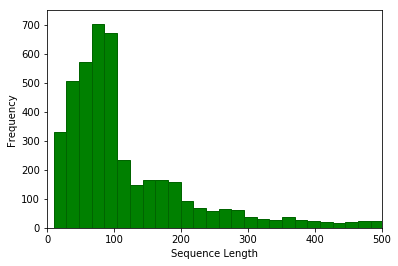

In [60]:
print("Average number of words per review: {:0.3f} \n".format(np.mean(length)))

plt.hist(length, 50, color='green', ec="darkgreen")
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.axis([0, 500, 0, 750])
plt.show()

In [20]:
max_length = 200
train_seq = []
for news in train_new.content:
    f = format_train_news(train_news = news, 
                            max_seq_len = max_length, 
                            word_list = load_word_lst)
    train_seq.append(f)
print("Processing is done")

Processing is done


In [21]:
test_seq = []
for news in df_xml.content:
    f = format_train_news(train_news = news, 
                            max_seq_len = max_length, 
                            word_list = load_word_lst)
    test_seq.append(f)
print("Processing is done")

Processing is done


### Data padding

In [22]:
train_pad = pad_sequences(train_seq, maxlen = max_length, padding='pre')
print("Length of data at index 10: {}\n".format(len(train_pad[10])))
print("Total number of news items: {}\n".format(len(train_pad)))
print("Data at index 10: \n{}".format(train_pad[10]))

Length of data at index 10: 200

Total number of news items: 4402

Data at index 10: 
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0   65  943   29   17
 2518   11   41 7652   17 7652  323 7652    8   17 7652    8  789 7652
    8   17 7652    8  264 7652    8   17 7652    8  177 1374  

In [23]:
test_pad = pad_sequences(test_seq, maxlen = max_length, padding='pre')
print("Length of data at 9th position: {}\n".format(len(test_seq[9])))
print("Total number of news items: {}\n".format(len(test_pad)))
print("Data at 11st position: \n{}".format(test_pad[10]))

Length of data at 9th position: 89

Total number of news items: 200

Data at 11st position: 
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0 7652   48    5   10 2545    6  178  560  530    3 6955
    6 1258    2   78 3810 7652 6329    2   16 7652  301  150 7652 7652
 7652  178 7652  135    1 7652    7 1466 2827   13 1189  383 7652    5
    1   34 1655  560    9    1 1053 1655    2 1282   52

In [24]:
print("Total number of words in our vocabulary: {}".format(len(load_word_lst)))

Total number of words in our vocabulary: 7653


In [25]:
print(train_clean[10].split())

['shr', '34', 'cts', 'vs', '119', 'dlrs', 'net', '807000', 'vs', '2858000', 'assets', '5102', 'mln', 'vs', '4797', 'mln', 'deposits', '4723', 'mln', 'vs', '4403', 'mln', 'loans', '2992', 'mln', 'vs', '3272', 'mln', 'note', '4th', 'qtr', 'not', 'available', 'year', 'includes', '1985', 'extraordinary', 'gain', 'from', 'tax', 'carry', 'forward', 'of', '132000', 'dlrs', 'or', 'five', 'cts', 'per', 'shr']


In [26]:
print("Index of word 'shr':       {}\n".format(load_word_lst.index('shr')))
print("Index of word '34':        {}\n".format(load_word_lst.index('34')))
print("Index of word 'cts':       {}\n".format(load_word_lst.index('cts')))

Index of word 'shr':       65

Index of word '34':        943

Index of word 'cts':       29



# Training

### Splitting data

In [27]:
x_train, x_valid, y_train, y_valid = train_test_split(train_pad, 
                                                    train_new.label, 
                                                    test_size = 0.2, 
                                                    random_state = 123)

print("Length of x_train: "+ str(x_train.shape))
print("Length of y_train: "+ str(y_train.shape) +" \n")
print("Shape of x_valid: "+ str(x_valid.shape))
print("Shape of y_valid: "+ str(y_valid.shape))

Length of x_train: (3521, 200)
Length of y_train: (3521,) 

Shape of x_valid: (881, 200)
Shape of y_valid: (881,)


In [29]:
y_train[y_train==0].count(),y_valid[y_valid==0].count()

(2780, 698)

In [30]:
y_train[y_train==1].count(),y_valid[y_valid==1].count()

(741, 183)

In [31]:
y_train.shape[0],y_valid.shape

(3521, (881,))

In [32]:
load_word_vec.shape[0],

(7653,)

### Modelling

In [167]:
# Ref [1,2]
model = Sequential()
model.add(Embedding(input_dim=load_word_vec.shape[0],
                    output_dim=load_word_vec.shape[1], 
                    weights=[load_word_vec],
                    input_length=max_length,
                    trainable=False))

i = Input(shape=(max_length,), dtype='int32', name='main_input')
x = embedding_layer(i)
x = Flatten()(x)
o = Dense(1, activation='sigmoid')(x)
model = Model(inputs=i, outputs=o)

In [423]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 200)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 200, 100)          765300    
_________________________________________________________________
flatten_6 (Flatten)          (None, 20000)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 20001     
Total params: 785,301
Trainable params: 20,001
Non-trainable params: 765,300
_________________________________________________________________


### Training Model

In [294]:
saved_mode = "./model/embed.h5"
batch_size = 64
num_epochs = 30

We use early stopping by setting `patience = 2` to prevent over-fitting:

In [295]:
callbacks_list = [keras.callbacks.EarlyStopping(monitor='acc', patience=2),
                  keras.callbacks.ModelCheckpoint(filepath=saved_mode, monitor='val_loss',save_best_only=True)]

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

built_model = model.fit(x_train, y_train, 
                        epochs=num_epochs, 
                        verbose=1, 
                        batch_size=batch_size,
                        validation_data=(x_valid, y_valid),
                        callbacks = callbacks_list)

Train on 3521 samples, validate on 881 samples
Epoch 1/30
3521/3521 [==============================] - 2s 535us/step - loss: 0.0045 - acc: 0.9997 - val_loss: 0.6894 - val_acc: 0.9376
Epoch 2/30
3521/3521 [==============================] - 0s 104us/step - loss: 0.0045 - acc: 0.9997 - val_loss: 0.6957 - val_acc: 0.9353
Epoch 3/30
3521/3521 [==============================] - 0s 95us/step - loss: 0.0045 - acc: 0.9997 - val_loss: 0.6965 - val_acc: 0.9364


After `3` epochs the training stopped and we got accuracy on validation set at `93.64%`.

### Predict on validation data

Now, let's use the trained model on our validation set. First we have to load our saved model and call `predict`:

In [296]:
saved_model = load_model(saved_mode)
y_pred = saved_model.predict(x_valid)
y_pred = (y_pred > 0.5)

In [297]:
saved_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 200)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 200, 100)          765300    
_________________________________________________________________
flatten_6 (Flatten)          (None, 20000)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 20001     
Total params: 785,301
Trainable params: 20,001
Non-trainable params: 765,300
_________________________________________________________________


Define a function to display confusion matrix on validation data:

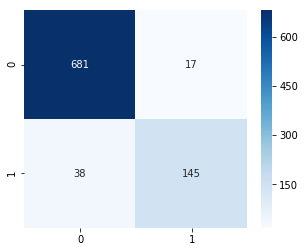

In [299]:
def print_cmx(y_true, y_pred):
    lbl = sorted(list(set(y_true)))
    cm = confusion_matrix(y_true,y_pred)
    df = pd.DataFrame(cm, index=lbl, columns=lbl)
    plt.figure(figsize = (5,4))
    sn.heatmap(df, annot=True,cmap='Blues', fmt='g')
    plt.show()
print_cmx(y_valid,y_pred)

# Predict on test data

In [377]:
y_pred_test = saved_model.predict(test_pad)
y_pred_test = (y_pred_test > 0.5)

In [409]:
empty_content_lst

['689.xml',
 '934.xml',
 '1247.xml',
 '1548.xml',
 '1717.xml',
 '2103.xml',
 '2169.xml',
 '2178.xml',
 '2244.xml',
 '2302.xml',
 '2442.xml',
 '2621.xml',
 '2698.xml',
 '3305.xml',
 '3678.xml',
 '3766.xml',
 '4565.xml',
 '4960.xml']

Get a list of label `1` items in our prediction test results and check them against our empty content list to make sure that non of the empty content items will be classified as company related earnings (label `1`).

In [306]:
np.where(y_pred_test)[0]

array([  3,   7,  14,  16,  18,  22,  39,  40,  41,  43,  51,  55,  58,
        60,  61,  64,  65,  66,  68,  69,  71,  74,  77,  85,  88,  94,
       103, 104, 115, 117, 121, 136, 148, 150, 153, 157, 160, 165, 166,
       167, 173, 178, 179, 188, 196])

In [413]:
for i in np.where(y_pred_test)[0]:
    file = df_xml.file.values[i]
    if file in empty_content_lst:
        print("In empty list ",file)
    else: print(file)

66.xml
165.xml
410.xml
484.xml
573.xml
640.xml
1090.xml
1124.xml
1135.xml
1157.xml
1320.xml
1446.xml
1546.xml
1566.xml
1586.xml
1643.xml
1645.xml
1655.xml
1706.xml
1716.xml
1722.xml
1763.xml
1849.xml
2092.xml
2137.xml
2212.xml
2396.xml
2398.xml
2659.xml
2691.xml
2771.xml
3258.xml
3637.xml
3669.xml
3680.xml
3713.xml
3772.xml
3875.xml
3894.xml
3971.xml
4169.xml
4292.xml
4347.xml
4583.xml
4819.xml


After checking, we can see that none of the empty content items have been classified with label `1`.
Below is the count for each label:
- Label `1`: 45 items
- Label `0`: 155 items

In [416]:
len(y_pred_test[y_pred_test==True]),len(y_pred_test[y_pred_test==False])

(45, 155)

#### Write test prediction to file

In [339]:
test_result_df = df_test
for index, value in enumerate(y_pred_test):
    if value == True:
        test_result_df.iloc[[index],2:] = 1
    else: test_result_df.iloc[[index],2:] = 0

In [340]:
test_result_df.head()

,id,file,earnings: 0 no/ 1 yes
0,20,20.xml,0
1,47,47.xml,0
2,57,57.xml,0
3,66,66.xml,1
4,88,88.xml,0


In [343]:
test_result_df.to_csv('word2vec_test_results.csv',index=False)

# References

1. DOAN Tu My, Learning Word-embeddings, Year-end project, https://github.com/doantumy/Word-Embeddings
- Jovian Lin, Embeddings in Keras: Train vs. Pretrained, https://jovianlin.io/embeddings-in-keras/
- Andreas Mueller, WordCloud package, https://github.com/amueller/word_cloud